# Summary

Test new `get_databunch` functionality to allow for supervised task.

In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
from fastai2.vision.all import show_image, show_images
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
                            precision_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F

from htools import *
from img_wang.data import load_img, get_databunch, ds_subset
from img_wang.models import Encoder, SingleInputBinaryModel, \
    TorchvisionEncoder
from img_wang.torch_utils import gpu_setup, top_mistakes
from incendio.callbacks import MetricHistory, ModelCheckpoint, EarlyStopper
from incendio.core import Trainer
from incendio.metrics import mean_soft_prediction, std_soft_prediction, \
    percent_positive

In [24]:
cd_root()
gpu_setup()

Current directory: /Users/hmamin/img_wang
Setting seeds for reproducible training.


/Users/hmamin/img_wang/lib/img_wang/torch_utils.py:84: UserWarning: Cuda not available.
  if not torch.cuda.is_available(): warnings.warn('Cuda not available.')
/Users/hmamin/img_wang/lib/img_wang/torch_utils.py:85: UserWarning: Incendio device is not cuda.
  if DEVICE.type != 'cuda': warnings.warn('Incendio device is not cuda.')


## Load Supervised DS

In [56]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/', mode='supervised',
                                   bs=9, max_train_len=18, max_val_len=18)

In [57]:
lmap(len, dst, dsv, dlt, dlv)

[18, 18, 2, 2]

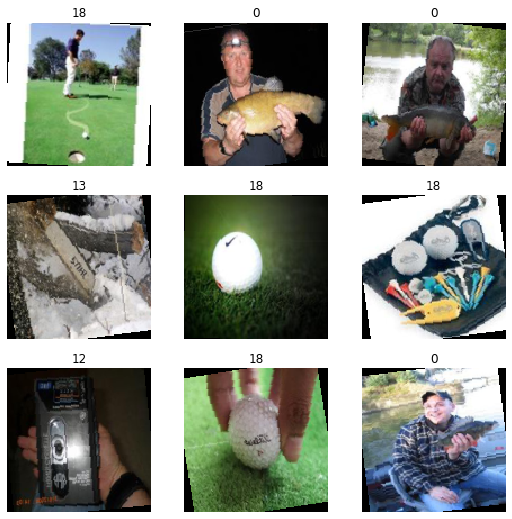

In [59]:
xb, yb = next(iter(dlt))
show_images(xb, nrows=3, titles=yb.tolist())

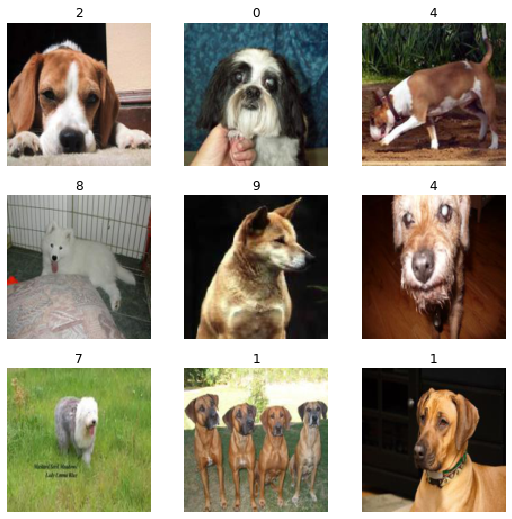

In [60]:
xb, yb = next(iter(dlv))
show_images(xb, nrows=3, titles=yb.tolist())

In [133]:
net = SingleInputBinaryModel(TorchvisionEncoder(), 
                             nn.Linear(2560, 1))

In [ ]:
state = torch.load('data/models/v9/trainer.pkl')
state.keys()

In [ ]:
net.load_state_dict(state['model'])

In [134]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            mode='binary', out_dir='data/models/v0', last_act=torch.sigmoid,
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img_wang'),
                       EarlyStopper('loss', 'min', patience=5)],
            metrics=[mean_soft_prediction, std_soft_prediction, percent_positive, 
                     accuracy_score, f1_score, recall_score, precision_score,
                     roc_auc_score])

In [135]:
t.load('trainer.pkl')

2020-09-16 05:47:02,828 [INFO]: Loading weights from data/models/v0/trainer.pkl.
